In [1]:
# import necessary libraries

# processing laryer
#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/preprocessing_layers.ipynb
#http://localhost:8888/lab/tree/MyQuantFinProject/SMart-AI/_sample_tf_google/tfcolumn_basic_feat_eng.ipynb

# others
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb
#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/int_logistic_regression.ipynb
#http://localhost:8888/lab/tree/MyQuantFinProject/SMart-AI/DemoDataTransform.ipynb

# tensorboard get start and all tutorial
#https://www.tensorflow.org/tensorboard/get_started
# https://www.tensorflow.org/tensorboard/scalars_and_keras
#https://keras.io/api/callbacks/tensorboard/ 
# https://medium.com/mpercept-academy/working-with-tensorboard-on-keras-callbacks-b8d680d451e7

#https://pair-code.github.io/lit/

import math

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures

from datetime import date, timedelta, datetime # Date Functions
import time


import os

import google.cloud.aiplatform as aip


from google.cloud import bigquery
from google.oauth2 import service_account
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# from google.cloud import aiplatform as vertex_ai
from tensorflow.python.keras.utils import data_utils

print(tf.__version__)
print(aip.__version__)



2.12.0
1.31.1


In [2]:
# Load the TensorBoard notebook extension.
#%load_ext tensorboard
%reload_ext tensorboard

In [24]:
cateCols=['sla','product_type','brand','service_type','incident_type']
numbericCols=['open_to_close_hour','response_to_resolved_hour']
unusedCols=['severity_id','severity_name','label_binary_severity']

# cateCols=['sla','product_type','service_type','incident_type']
# numbericCols=['open_to_close_hour']
# unusedCols=['severity_id','severity_name','label_binary_severity','brand','response_to_resolved_hour']

labelCol='label_multi_severity'

model_dir='model_v2' # production
# model_dir='gs://demo2-tf-incident-pongthorn/demo_model_tf' # demo

main_metric='accuracy'
main_objective=f'val_{main_metric}'

n_epochs= 200 #100
n_batch_size=32
nEarlyPatience= int(n_epochs/10)+1  # 10

tsb_path="tsb_logs/fit/"

# df['label_multi_severity'] =df['severity_name'].map({'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3}) 

In [4]:
# Load data from BigQuery
#projectId='smart-data-ml'
# credentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
# client = bigquery.Client(credentials=credentials, project=projectId)

projectId='pongthorn'
client = bigquery.Client(project=projectId)
dataset_id='SMartML'

train_name='train_incident'
validation_name='validation_incident'
test_name='test_incident'

# Load Data

In [5]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
  
 return df

In [6]:
train_table_id=f"{projectId}.{dataset_id}.{train_name}"
val_tabel_id=f"{projectId}.{dataset_id}.{validation_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"

train=load_data_bq(f"SELECT * FROM {train_table_id}")
val=load_data_bq(f"SELECT * FROM {val_tabel_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

# Load data from CSV File
# root_path='../../data'    
# train = load_ml_data(f"{root_path}/{train_name}.csv")
# val=load_ml_data(f"{root_path}/{validation_name}.csv")
# test =load_ml_data(f"{root_path}/{test_name}.csv")

print(train.shape)
print(val.shape)
print(test.shape)


(2731, 8)
(341, 8)
(342, 8)


In [7]:
labelList=list(train[labelCol].unique())
print("List All Label:" ,sorted(labelList))
nLabel=len(labelList)
print(f"No target label : {nLabel}")

print(train.info())
train.tail()

List All Label: [0, 1, 2, 3]
No target label : 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731 entries, 0 to 2730
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sla                        2731 non-null   object 
 1   product_type               2731 non-null   object 
 2   brand                      2731 non-null   object 
 3   service_type               2731 non-null   object 
 4   incident_type              2731 non-null   object 
 5   open_to_close_hour         2731 non-null   float64
 6   response_to_resolved_hour  2731 non-null   float64
 7   label_multi_severity       2731 non-null   Int64  
dtypes: Int64(1), float64(2), object(5)
memory usage: 173.5+ KB
None


,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,label_multi_severity
2726,24x7 4Hrs Response Time,Security,Trend Micro,Request,General Incident,0.333333,0.333333,0
2727,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,0.883333,0.716667,0
2728,24x7 4Hrs Response Time,Security,Trend Micro,Request,OS / Firmware,16.666667,16.666667,0
2729,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,7.400000,7.283333,0
2730,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,5.483333,5.483333,0


In [8]:
def CalPctEachTargetClass(dfx,colSev,colPctSev):
    dfClassSummary=dfx.groupby([labelCol]).size().to_frame(colSev)
    dfClassSummary[colPctSev]= dfClassSummary[colSev]/dfClassSummary[colSev].sum() *100
    dfClassSummary=dfClassSummary.round(0)
    return dfClassSummary

pctDF1=CalPctEachTargetClass(train,'Train-No-Severity','Train-%-Severity')
pctDF2=CalPctEachTargetClass(val,'Val-No-Severity','Val-%-Severity')
pdcDF3=CalPctEachTargetClass(test,'Test-No-Severity','Test-%-Severity')
pctDF=pd.concat([pctDF1,pctDF2,pdcDF3],axis=1)

pctDF

,Train-No-Severity,Train-%-Severity,Val-No-Severity,Val-%-Severity,Test-No-Severity,Test-%-Severity
label_multi_severity,,,,,,
0,511,19.0,53,16.0,55,16.0
1,778,28.0,97,28.0,92,27.0
2,1341,49.0,180,53.0,181,53.0
3,101,4.0,11,3.0,14,4.0


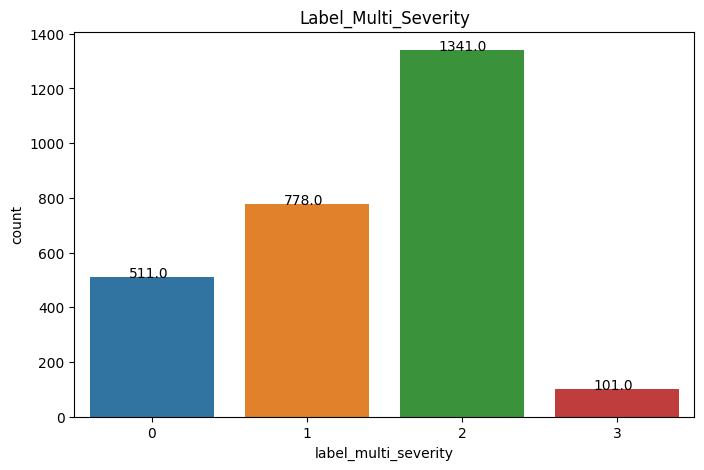

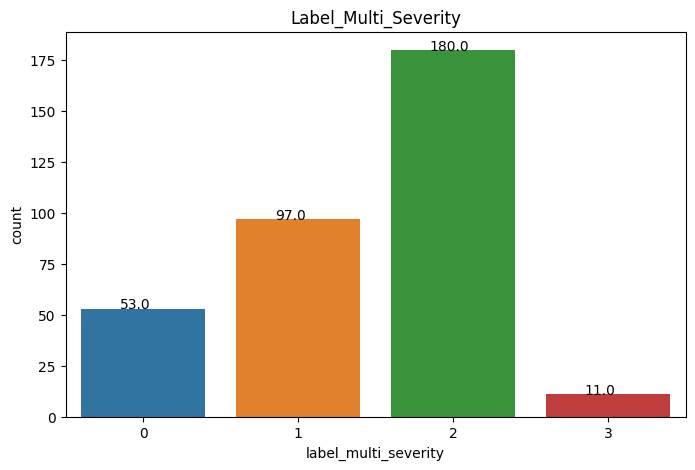

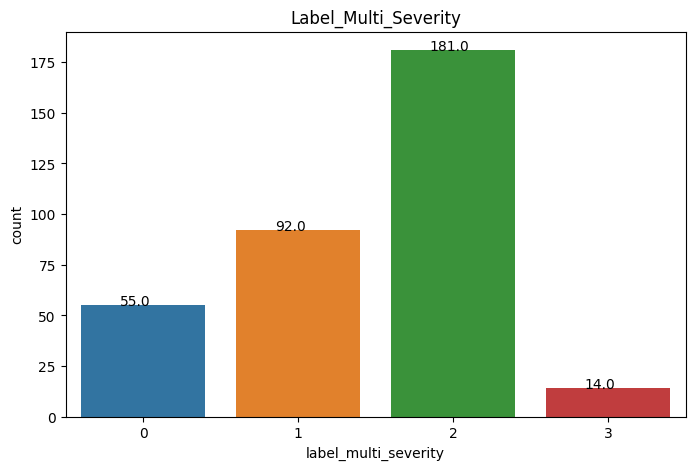

In [9]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x=labelCol, data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol.title())
    plt.show()
    
plot_class(train)
plot_class(val)
plot_class(test)

# Process Data  Layer

In [10]:
def multiple_label_df_to_dataset(dataframe, shuffle=True, batch_size=32):
  features = dataframe.copy()
  labels = features.pop(labelCol)
  labels  = tf.keras.utils.to_categorical(labels, num_classes=nLabel)
    
  ds = tf.data.Dataset.from_tensor_slices(( dict(features), labels ))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
     
     

In [11]:
print("Explore Data from Tensor before keras data processing")
batch_size = 1
train_ds =multiple_label_df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print("========Features==========")
print('Every feature:', list(train_features.keys()))
print('product_type:', train_features['product_type'])  # sample cate feature
print('open_to_close_hour:', train_features['open_to_close_hour'])  # sample numberic feature


Explore Data from Tensor before keras data processing
========Features==========
Every feature: ['sla', 'product_type', 'brand', 'service_type', 'incident_type', 'open_to_close_hour', 'response_to_resolved_hour']
product_type: tf.Tensor([b'Firewall'], shape=(1,), dtype=string)
open_to_close_hour: tf.Tensor([0.53333333], shape=(1,), dtype=float64)


In [12]:
print("========Labels==========")
print(f'{label_batch }')

========Labels==========
[[0. 0. 1. 0.]]


In [13]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [14]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

In [15]:
hour_col = train_features['open_to_close_hour']
layer = get_normalization_layer('open_to_close_hour', train_ds)
layer(hour_col)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.3536911], dtype=float32)>

In [16]:
# total no type+unkonw
print(train['product_type'].unique())
type_col = train_features['product_type']
layer = get_category_encoding_layer('product_type', train_ds, 'string')
layer(type_col)

# onehot-encoding = 10 category+unknown=11 columnn

['Other' 'Printer' 'Storage' 'Software' 'Server' 'Access Point' 'Switch'
 'Hardware' 'Tape Library' 'Security' 'Service' 'Notebook' 'Firewall']


<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [17]:
batch_size =32
train_ds = multiple_label_df_to_dataset (train, batch_size=batch_size)
val_ds = multiple_label_df_to_dataset(val, batch_size=batch_size)
test_ds = multiple_label_df_to_dataset(test, batch_size=batch_size)
# for element in train_ds.as_numpy_iterator():
#     print(element)

# Data Transformation by Keras PreProcessing Layer 

In [18]:
all_inputs = []
encoded_features = []
numInputFeatToInitNodeUnit=0

# Numeric features.
for header in numbericCols:
  stat_data=train[header].describe()
  print(f"header: Mean={stat_data['mean']} and Std={stat_data['std']}")  
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)
    
numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+len(numbericCols)
    
    # Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
  listCateItem=train[header].unique()
  noCateItem=len(listCateItem)
  numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+noCateItem +1  # last 1 is unknow  
  print(f"{header} = {noCateItem} : {listCateItem}")

  print(header)  
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


header: Mean=120.7417429512999 and Std=339.9325107996055
header: Mean=92.4087208592701 and Std=292.40800375934094
sla = 7 : ['24x7 4Hrs Resolution Time' '24x7 4Hrs Response Time'
 '24x7 6Hrs Resolution Time' '8x5 4Hrs Response Time'
 '9x5 NBD 4Hrs Response Time' '24x7 6Hrs Response Time' 'Non MA']
sla
product_type = 13 : ['Other' 'Printer' 'Storage' 'Software' 'Server' 'Access Point' 'Switch'
 'Hardware' 'Tape Library' 'Security' 'Service' 'Notebook' 'Firewall']
product_type
brand = 28 : ['F5' 'HP' 'EMC' 'HPE' 'IBM' 'YIP' 'DELL' 'QNAP' 'Cisco' 'SAPB1' 'Veeam'
 'NetApp' 'Oracle' 'VMWare' 'Zabbix' 'eUnite' 'Nutanix' 'Red Hat'
 'Veritas' 'Alfresco' 'Broadcom' 'Fortinet' 'Commvault' 'Microsoft'
 'Palo Alto' 'CIMCO-CMMS' 'CheckPoint' 'Trend Micro']
brand
service_type = 2 : ['Incident' 'Request']
service_type
incident_type = 21 : ['General Incident' 'Network Adapter Failure' 'Software'
 'Maintenance System' 'Hard Disk Drive Failure' 'Power Supply Failure'
 'Report' 'System Board Failure' 'Me

In [19]:
print(f"Total column to initialize first node input: {numInputFeatToInitNodeUnit}")

Total column to initialize first node input: 78


# Build and Train and Eveluate and Plot Result

In [20]:
def plot_metrics(history,metric):
    plt.figure(figsize=(15,8))
    plt.title(metric)
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history[f'val_{metric}'], label='validation')
    plt.legend()
    plt.show() 


In [21]:
# logdir = f"{tsb_path}/scalars" + datetime.now().strftime("%Y%m%d-%H%M%S")
# file_writer = tf.summary.create_file_writer(logdir + "/metrics")
# file_writer.set_as_default()


# def lr_schedule(epoch):
#   """
#   Returns a custom learning rate that decreases as epochs progress.
#   """
#   learning_rate = 0.01 # default
#   if epoch >= 50:
#     learning_rate = 0.001   # default
#   if epoch >= 100:
#     learning_rate = 0.0001
#   if epoch > 150:
#     learning_rate = 0.00001

#   tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
#   return learning_rate



In [22]:

# def build_model(num_units_1,num_units_layer2, dropout_rate):
def build_model(num_units_layer1, dropout_rate,learningRate,no_addtional_hidden_layer=1):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
   
    x = tf.keras.layers.Dense(num_units_layer1, activation="relu")(all_features)# layer1
    
    if dropout_rate>0:
     print(f"Dropout: { dropout_rate}")
     x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # if no_addtional_hidden_layer>1:
    # for x  in range(0,1):  
    # x = tf.keras.layers.Dense(num_units_layer1, activation="relu")(x)  # layer2


    output = tf.keras.layers.Dense(nLabel,activation=tf.nn.softmax)(x)

    model = tf.keras.Model(all_inputs, output)
    
    if  learningRate==0:
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[main_metric])
    else:
        print(f"LR: {learningRate}")
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate),
                      loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[main_metric])
    return model

def train_model(model,x_epochs,x_batch_size):  
    # model.summary()

    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=nEarlyPatience, verbose=1)  
    # history =model.fit(train_ds, validation_data=val_ds,epochs=x_epochs,batch_size=x_batch_size,callbacks=[early_stopping])
    
    log_dir = f"{tsb_path}" + datetime.now().strftime("%Y%m%d-%H%M")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    
    history =model.fit(train_ds, validation_data=val_ds,epochs=x_epochs,batch_size=x_batch_size,
                       callbacks=[early_stopping,tensorboard_callback])
    
     # lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    # history =model.fit(train_ds, validation_data=val_ds,epochs=x_epochs,batch_size=x_batch_size,
    #                    callbacks=[early_stopping,tensorboard_callback, lr_callback ])
    return history


# def build_wide_deep_model()
# METRICS = [
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
# ]
  

# Test Run Model

In [25]:
print("1#Build model")

# Smaller RL , longer , By doing this, you learn gradually rather than jumping around 
#A learning rate of 0.001 is the default (Adam)

#model=build_model(32,0.1,0.0001)
model=build_model(64,0.1,0.0001)
#model=build_model(numInputFeatToInitNodeUnit,0,0)

# print(model.summary())
#model=build_model(128,0,0)


1#Build model
Dropout: 0.1
LR: 0.0001


In [26]:
print("2#Train model")
history=train_model(model,n_epochs,n_batch_size)
print("=============================================================================")


2#Train model
Epoch 1/200
86/86 [==============================] - 3s 11ms/step - loss: 1.4505 - accuracy: 0.1516 - val_loss: 1.3795 - val_accuracy: 0.2053
Epoch 2/200
86/86 [==============================] - 0s 5ms/step - loss: 1.3499 - accuracy: 0.3252 - val_loss: 1.2847 - val_accuracy: 0.5161
Epoch 3/200
86/86 [==============================] - 0s 5ms/step - loss: 1.2691 - accuracy: 0.4599 - val_loss: 1.2082 - val_accuracy: 0.5249
Epoch 4/200
86/86 [==============================] - 0s 5ms/step - loss: 1.2068 - accuracy: 0.5009 - val_loss: 1.1439 - val_accuracy: 0.5572
Epoch 5/200
86/86 [==============================] - 1s 7ms/step - loss: 1.1491 - accuracy: 0.5181 - val_loss: 1.0894 - val_accuracy: 0.5718
Epoch 6/200
86/86 [==============================] - 1s 7ms/step - loss: 1.1006 - accuracy: 0.5339 - val_loss: 1.0441 - val_accuracy: 0.5748
Epoch 7/200
86/86 [==============================] - 1s 7ms/step - loss: 1.0627 - accuracy: 0.5434 - val_loss: 1.0051 - val_accuracy: 0.610

In [28]:
print("3#Evaluate model")

loss_val, accuracy_val = model.evaluate(val_ds)
print(f"Average Loss - Accuracy on Eveluation {loss_val} -{accuracy_val}")

loss_test, accuracy_test = model.evaluate(test_ds)
print(f"Average Loss - Accuracy on Test {loss_test} -{accuracy_test}")

print("=============================================================================")


# production data set to 12MAr23
# 7/7 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.7689
# Average Loss - Accuracy on Eveluation 0.6654592752456665 -0.7688679099082947
# 7/7 [==============================] - 0s 2ms/step - loss: 0.6977 - accuracy: 0.7358
# Average Loss - Accuracy on Test 0.6977102160453796 -0.7358490824699402


# demo set to 04 April23
# 8/8 [==============================] - 0s 2ms/step - loss: 0.7334 - accuracy: 0.7621
# Average Loss - Accuracy on Eveluation 0.7333917617797852 -0.7621145248413086
# 8/8 [==============================] - 0s 3ms/step - loss: 0.7452 - accuracy: 0.6740
# Average Loss - Accuracy on Test 0.745168149471283 -0.6740087866783142
# ============================================================================

3#Evaluate model
11/11 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.7243
Average Loss - Accuracy on Eveluation 0.6925034523010254 -0.7243402004241943
11/11 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.7076
Average Loss - Accuracy on Test 0.6708818674087524 -0.707602322101593


In [30]:
# Log result with Tensorboad
# !kill 18800
# load and use jupyter notebok
# %tensorboard --logdir tsb_logs/fit/  --host 0.0.0.0

#tensorboard --logdir=ilogs/ --port=6006
#%tensorboard --logdir tsb_logs/fit/
# ! del /f ./logs/

from tensorboard import notebook
notebook.list() # View open TensorBoard instances

notebook.display(port=6006, height=1000)


Known TensorBoard instances:
  - port 6006: logdir logs/fit (started 4:38:51 ago; pid 13184)
  - port 6006: logdir tsb_logs/fit/ (started 1:11:31 ago; pid 15264)
  - port 6006: logdir tsb_logs/tune/ (started 0:04:51 ago; pid 15424)
  - port 6006: logdir logs/fit (started 4:42:50 ago; pid 17184)
  - port 6006: logdir tsb_logs/fit/ (started 0:34:32 ago; pid 18800)
Selecting TensorBoard with logdir tsb_logs/tune/ (started 0:04:51 ago; port 6006, pid 15424).


4#Explore Result model


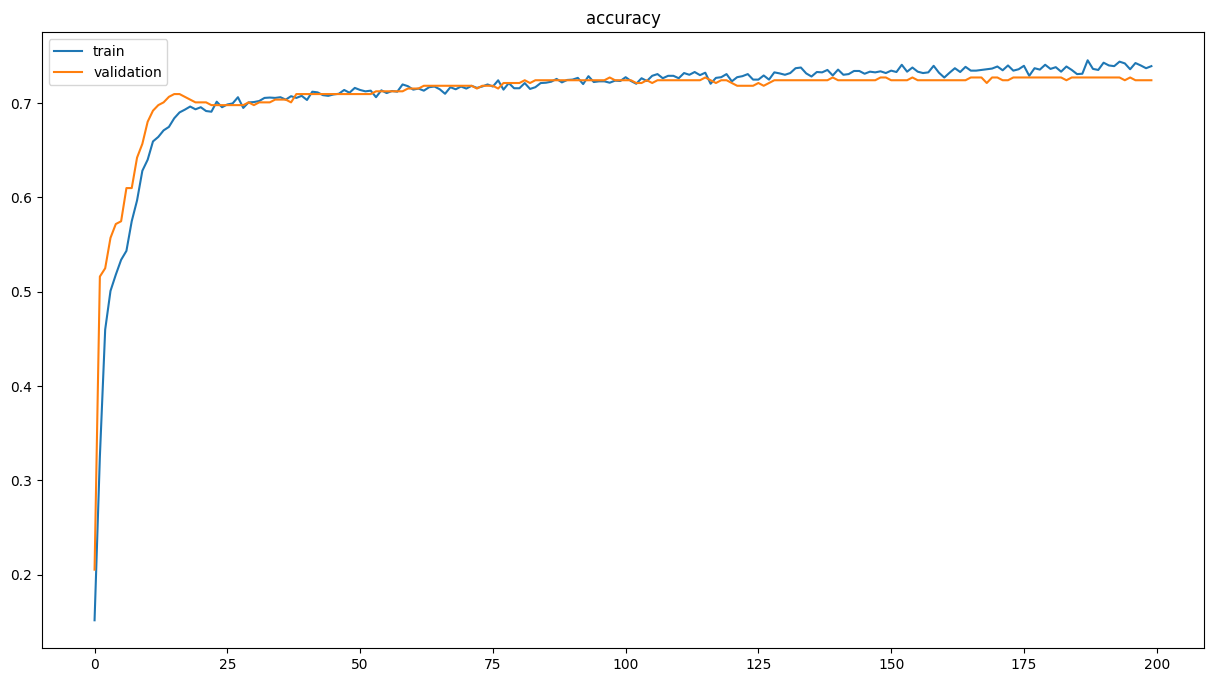

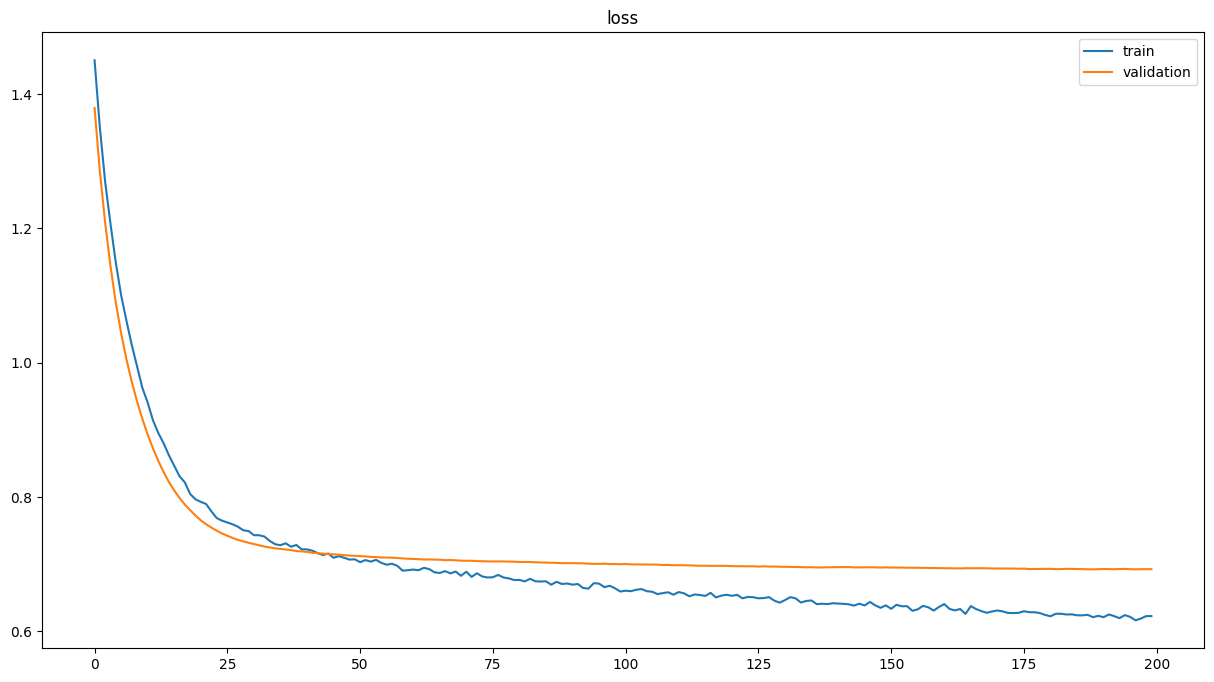

In [31]:
print("4#Explore Result model")
plot_metrics(history,main_metric)
plot_metrics(history,"loss")


# Save Model

In [32]:
model.save(model_dir)


INFO:tensorflow:Assets written to: model_v2\assets


INFO:tensorflow:Assets written to: model_v2\assets


# Try Prediction

In [33]:
#label_multi_severity

local_model= tf.keras.models.load_model(model_dir)

sample={"sla":"24x7 4Hrs Response Time",
        "product_type":"Server",
        "brand":"VMWare",                
        "service_type":"Incident",
        "incident_type":"General Incident",
        "open_to_close_hour":12,
        "response_to_resolved_hour":8.500000 \
       }

print(sample)
              
print("===============================================================================================================")    
print("convert pain data to serdor as input to predict")    
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
print(input_dict)

predictionList = local_model.predict(input_dict)
print(predictionList)

prob = tf.nn.softmax(predictionList[0])
print(f"{(100 * prob)} % at {np.argmax(prob, axis=0)} as Severity") 


{'sla': '24x7 4Hrs Response Time', 'product_type': 'Server', 'brand': 'VMWare', 'service_type': 'Incident', 'incident_type': 'General Incident', 'open_to_close_hour': 12, 'response_to_resolved_hour': 8.5}
convert pain data to serdor as input to predict
{'sla': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'24x7 4Hrs Response Time'], dtype=object)>, 'product_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Server'], dtype=object)>, 'brand': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'VMWare'], dtype=object)>, 'service_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Incident'], dtype=object)>, 'incident_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'General Incident'], dtype=object)>, 'open_to_close_hour': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([12])>, 'response_to_resolved_hour': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.5], dtype=float32)>}
1/1 [==============================] - 1s 687ms/step
[[0.04325395 0.345152

# Copy Model From Local To GCS

In [ ]:
# # #https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations?hl=en#6
# # press_y3=input(f"Press y=True to save model to Google Cloud storage : ") 
# # if press_y3.lower()=='y':
# MODEL_BUCKET = 'gs://tf1-incident-smart-ml-yip'

# # # # !gsutil mb -l $REGION $MODEL_BUCKET
# # !gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/demo_model
# !gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/model
# #!gsutil -m cp -r ./$explain_meta_model_dir/* $MODEL_BUCKET/demo_model_explain_meta
# # else:
# #  quite()
